In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Import

This part prepares extra data for my main dataset with physician info. 
This one adds data on how many drugs each physician prescribes (prescribed in 2018).
Note that this data is aggregated and can be added only after the main dataset is aggregated,so that each row represents a unique physician

In [2]:


#getting prescriptions data from CMS
df = pd.read_csv(r'D:/PartD_Prescriber_PUF_NPI_18.txt',sep='\t',header=(0))
print(df.head())
#selecting only the columns we need - how many drugs prescribed and total cost
df = df [['npi','total_claim_count','total_drug_cost']]
print(df.head())
#summarizing data by provider
df = df.groupby('npi').sum()
print(df.shape)
print(df.head())
# saving dataset to push it my SQL server
df.to_csv('D:/Data Repo/Mila/2018_prescriptions_summary_data.csv')

          npi nppes_provider_last_org_name nppes_provider_first_name  \
0  1003000126                    ENKESHAFI                   ARDALAN   
1  1003000142                       KHALIL                    RASHID   
2  1003000167                      ESCOBAR                     JULIO   
3  1003000282                    BLAKEMORE                     ROSIE   
4  1003000407                      GIRARDI                     DAVID   

  nppes_provider_mi nppes_credentials nppes_provider_gender nppes_entity_code  \
0               NaN              M.D.                     M                 I   
1               NaN              M.D.                     M                 I   
2                 E               DDS                     M                 I   
3                 K               FNP                     F                 I   
4                 J              D.O.                     M                 I   

       nppes_provider_street1 nppes_provider_street2 nppes_provider_city  ...  \

This part creates the main dataset with physician info for each impression in 2020 by connecting to the SQL server
and running the query below. To calculate the target variable, the amount of money each prescriber 'earned' for the company, this data set needs to be aggregated by npi.

In [12]:
#TO DO BEFORE SUBMISSION - REMOVE CREDENTIALS
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine(
    "credentials hidden",
)

QUERY = """
SELECT
m.npi AS 'npi', 
r.first_name AS first_name,
r.last_name AS last_name,
IFNULL(r.gender, 'N/A') AS gender,
IFNULL(r. address1, 'N/A') AS address,
IFNULL(r.city, 'N/A') AS city,
r.state AS state,
LEFT(r.zipcode,5) AS zipcode,
r. sole_proprietor_ind AS sole_proprietor,
r.medicare_ind, 
medicaid_ind,
t.name AS 'specialty',
total_procedures,
distinct_procedures,
institution,
derived_specialty_list,
event_ts,
adiolineitemid,
li.costperdrop,
dropsize,
costperdrop/dropsize as impression_cost,
r.cbm_id,
CASE client_key				
	WHEN 'AMAEXPAND'			
		THEN 'AMA'		
	WHEN 'RDBDMD'			
		THEN 'RDB'		
	WHEN 'NEUROCCF'			
		THEN 'NEURO'		
	WHEN 'NEURODMD'			
		THEN 'NEURO'		
	WHEN 'CCRADIODMD'			
		THEN 'CCRADIO'		
	WHEN 'CCENDODMD'			
		THEN 'CCENDO'		
	WHEN 'DENTALRD'			
		THEN 'DENTAL'		
	WHEN 'DENTALDMD'			
		THEN 'DENTAL'		
	WHEN 'DENTALHEALTHLINK'			
		THEN 'DENTAL'		
	ELSE client_key			
	END AS 'publicationid',
clients.is_pii_enabled,
h.city AS hospital_city, 
h.state AS hospital_state,
LEFT(h.zipcode,5) as hospital_zip,
h.latitude AS hospital_latitude,
h.longitude AS hospital_longitude,
h.hospital_size AS hospital_size,
h.system_member AS hospital_system_membership

FROM research.ad_io_line_item_drop_event e 
		INNER JOIN research.adiolineitemdrop d ON (e.ad_io_line_item_drop_id = d.adiolineitemdropid)
		INNER JOIN research.adiolineitem li USING(adiolineitemid)
		INNER JOIN
		research.recipients r ON (e.recipient_id = r.cbm_id)
		INNER JOIN
		research.clients USING(client_id)
		INNER JOIN
		research.recipientmatch m ON (r.cbm_id = m.cbm_id AND total_score >= 65)
        LEFT JOIN  research.npitaxonomy USING (npi)
		LEFT JOIN  research.taxonomy t ON (npitaxonomy.taxonomy_code = t.code)
        LEFT JOIN temp_darcy.hospital_affiliation USING(npi)
        LEFT JOIN temp_darcy.hospital h USING(ccn)
        LEFT JOIN (SELECT npi, count(procedure_name) AS total_procedures, count(distinct procedure_name) AS distinct_procedures
					FROM temp_darcy.procedures
					GROUP BY npi) as procedures USING (npi)

	WHERE runstatus = 'Y'
	AND date(event_ts) BETWEEN '2020-01-01' AND '2020-03-01'
    AND dropsize > 0
    AND costperdrop > 0
    LIMIT 200000
"""

with engine.connect() as con:
    rs = con.execute(QUERY)
    df_main = pd.DataFrame(rs.fetchall()) #fetchall() lists all results
    df_main.columns = rs.keys()
    con.close()
print(df_main.head())
print(df_main.shape)

          npi          first_name last_name gender address       city state  \
0  1316146061  Florello Sven-Erik  Quianzon    N/A     N/A  SKOWHEGAN    ME   
1  1316146061  Florello Sven-Erik  Quianzon    N/A     N/A  SKOWHEGAN    ME   
2  1316146061  Florello Sven-Erik  Quianzon    N/A     N/A  SKOWHEGAN    ME   
3  1316146061  Florello Sven-Erik  Quianzon    N/A     N/A  SKOWHEGAN    ME   
4  1316146061  Florello Sven-Erik  Quianzon    N/A     N/A  SKOWHEGAN    ME   

  zipcode sole_proprietor medicare_ind  ...   cbm_id publicationid  \
0   04976               N            N  ...  5094890           CCF   
1   04976               N            N  ...  5094890           CCF   
2   04976               N            N  ...  5094890           CCF   
3   04976               N            N  ...  5094890           CCF   
4   04976               N            N  ...  5094890           CCF   

   is_pii_enabled  hospital_city hospital_state hospital_zip  \
0         b'\x01'      Skowhegan        

In [16]:
#saving the dataframe so we don't have to fetch it every time
df_main.to_csv('C:/Users/emich/Google Drive/Data science/Capstone 3/Data/Data_main.csv', index=False)

# Combining Datasets

In [43]:
df_main = pd.read_csv(r'C:/Users/emich/Google Drive/Data science/Capstone 3/Data/Data_main.csv')

In [44]:
print(df_main.head())
print (df_main.shape)

          npi first_name last_name gender address       city state zipcode  \
0  1518226661       Ryan  Sychterz      M     NaN        BOW    NH   03304   
1  1518226661       Ryan  Sychterz      M     NaN        BOW    NH   03304   
2  1942444237      Sarah      Finn    NaN     NaN  NEWFIELDS    NH   03856   
3  1942444237      Sarah      Finn    NaN     NaN  NEWFIELDS    NH   03856   
4  1942444237      Sarah      Finn    NaN     NaN  NEWFIELDS    NH   03856   

  sole_proprietor medicare_ind  ...   cbm_id publicationid  is_pii_enabled  \
0               N            N  ...  5918490         SEMPA         b'\x01'   
1               N            N  ...  5918490         SEMPA         b'\x01'   
2               N            N  ...  5753963           AMA         b'\x00'   
3               N            N  ...  5753963           AMA         b'\x00'   
4               N            N  ...  5753963           AMA         b'\x00'   

   hospital_city hospital_state hospital_zip hospital_latitude

In [45]:
#from the main dataframe summarizing how much money each doctor generated by summing all impressions and 
#impression costs for each unique npi
df_money = df_main.groupby('npi')['impression_cost'].sum().reset_index(name='money_generated')
df_impressions = df_main.groupby('npi')['event_ts'].count().reset_index(name='impressions_count')
df_money = pd.merge(df_money,df_impressions, on='npi')
print(df_money.shape)
print(df_money.head())

(13914, 3)
          npi  money_generated  impressions_count
0  1003000415         0.072093                  3
1  1003011610         0.129176                 32
2  1003012436         0.003150                  1
3  1003012634         2.835712                 20
4  1003015785         0.022761                  1


In [46]:
data = df_money.merge(df_main, how='left', on='npi')
data.drop_duplicates(subset='npi',inplace=True)
print(data.shape)
print(data.head())
print(data.columns)

(13914, 33)
           npi  money_generated  impressions_count first_name last_name  \
0   1003000415         0.072093                  3   Marshall   Webster   
3   1003011610         0.129176                 32      Alaka       Ray   
35  1003012436         0.003150                  1      Maged   Soliman   
36  1003012634         2.835712                 20     Dunyue        Lu   
56  1003015785         0.022761                  1       Ryan    Rogers   

   gender               address         city state zipcode  ...   cbm_id  \
0     NaN                   NaN   PITTSBURGH    PA   15238  ...  1730358   
3     NaN                   NaN  NEWTONVILLE    MA   02460  ...  6141181   
35    NaN                   NaN        ISLIP    NY   11751  ...  6597601   
36    NaN                   NaN         Troy    MI   48098  ...  5098997   
56    NaN  31 North Main Street      Rutland    VT   05701  ...  6094117   

   publicationid is_pii_enabled hospital_city  hospital_state  hospital_zip  \
0

In [47]:
#Next step: merge prescriptions data
prescriptions = pd.read_csv('D:/Data Repo/Mila/2018_prescriptions_summary_data.csv')
print(prescriptions.head())
prescriptions.shape

data = data.merge(prescriptions, on='npi', how='left')
print(data.head())
data.shape


          npi  total_claim_count  total_drug_cost
0  1003000126                492         27744.26
1  1003000142               1818        124220.94
2  1003000167                 77           502.88
3  1003000282                100          5132.53
4  1003000407               2766        118165.29
          npi  money_generated  impressions_count first_name last_name gender  \
0  1003000415         0.072093                  3   Marshall   Webster    NaN   
1  1003011610         0.129176                 32      Alaka       Ray    NaN   
2  1003012436         0.003150                  1      Maged   Soliman    NaN   
3  1003012634         2.835712                 20     Dunyue        Lu    NaN   
4  1003015785         0.022761                  1       Ryan    Rogers    NaN   

                address         city state zipcode  ... is_pii_enabled  \
0                   NaN   PITTSBURGH    PA   15238  ...        b'\x00'   
1                   NaN  NEWTONVILLE    MA   02460  ...        b'

(13914, 35)

# Data Cleansing

In [53]:
#getting rid of the columns that won't be useful:
data.columns

data = data[['npi', 'money_generated', 'impressions_count','gender', 'city', 'state', 'zipcode',
       'sole_proprietor','specialty',
       'total_procedures', 'distinct_procedures', 'institution',
       'derived_specialty_list', 'event_ts','impression_cost', 'cbm_id', 'publicationid',
       'is_pii_enabled', 'hospital_city', 'hospital_state', 'hospital_zip',
       'hospital_latitude', 'hospital_longitude', 'hospital_size',
       'hospital_system_membership', 'total_claim_count',
       'total_drug_cost']]

data.shape

(13914, 27)

In [54]:
data.describe()

,npi,money_generated,impressions_count,total_procedures,distinct_procedures,impression_cost,cbm_id,hospital_latitude,hospital_longitude,total_claim_count,total_drug_cost
count,1.391400e+04,13914.000000,13914.000000,6074.000000,6074.000000,13914.000000,1.391400e+04,4844.000000,4844.000000,8929.000000,8.929000e+03
mean,1.495852e+09,0.801886,14.374012,52.125453,18.434969,0.045338,5.773646e+06,38.184568,-89.289734,1033.611491,1.548504e+05
std,2.864939e+08,6.159175,74.776296,62.869930,19.768780,0.059325,1.475171e+06,5.177444,16.156617,2656.972489,4.332643e+05
min,1.003000e+09,0.001534,1.000000,1.000000,1.000000,0.001515,1.537517e+06,13.463100,-161.787000,11.000000,2.209000e+01
25%,1.245636e+09,0.016601,2.000000,13.000000,6.000000,0.003489,5.000971e+06,34.200250,-95.623600,49.000000,8.513600e+02
50%,1.497196e+09,0.073613,4.000000,31.000000,12.000000,0.006496,6.099265e+06,39.772100,-84.363550,164.000000,8.203630e+03
75%,1.740414e+09,0.366000,10.000000,67.000000,24.000000,0.084296,6.908590e+06,41.754100,-76.662200,762.000000,1.049590e+05
max,1.993000e+09,392.581244,4392.000000,679.000000,164.000000,1.093289,8.204145e+06,61.563200,-65.978200,45892.000000,8.910559e+06


The max for impression_cost and count looks unrealistic. It's likely that the opens generated by a robot.Might need to look at the overall distribution.Hospital zip is likely an object, but it's treated like an integer. Data type needs to be changed.

In [55]:
data.dtypes

npi                             int64
money_generated               float64
impressions_count               int64
gender                         object
city                           object
state                          object
zipcode                        object
sole_proprietor                object
specialty                      object
total_procedures              float64
distinct_procedures           float64
institution                    object
derived_specialty_list         object
event_ts                       object
impression_cost               float64
cbm_id                          int64
publicationid                  object
is_pii_enabled                 object
hospital_city                  object
hospital_state                 object
hospital_zip                   object
hospital_latitude             float64
hospital_longitude            float64
hospital_size                  object
hospital_system_membership     object
total_claim_count             float64
total_drug_c

In [56]:
data['hospital_zip'] = data['hospital_zip'].astype(str)
data.dtypes

npi                             int64
money_generated               float64
impressions_count               int64
gender                         object
city                           object
state                          object
zipcode                        object
sole_proprietor                object
specialty                      object
total_procedures              float64
distinct_procedures           float64
institution                    object
derived_specialty_list         object
event_ts                       object
impression_cost               float64
cbm_id                          int64
publicationid                  object
is_pii_enabled                 object
hospital_city                  object
hospital_state                 object
hospital_zip                   object
hospital_latitude             float64
hospital_longitude            float64
hospital_size                  object
hospital_system_membership     object
total_claim_count             float64
total_drug_c

In [57]:
#exploring NULL values
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13914 entries, 0 to 13913
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   npi                         13914 non-null  int64  
 1   money_generated             13914 non-null  float64
 2   impressions_count           13914 non-null  int64  
 3   gender                      2028 non-null   object 
 4   city                        13625 non-null  object 
 5   state                       13606 non-null  object 
 6   zipcode                     13660 non-null  object 
 7   sole_proprietor             13835 non-null  object 
 8   specialty                   13914 non-null  object 
 9   total_procedures            6074 non-null   float64
 10  distinct_procedures         6074 non-null   float64
 11  institution                 872 non-null    object 
 12  derived_specialty_list      10061 non-null  object 
 13  event_ts                    139

From the above, it looks like most records are missing gender info as well as institution. We'll drop these columns.
In addition hospital membembership is missing half of the values. Let's see if this an empty cell means the value is truly missing

In [58]:
data['hospital_system_membership'].unique()

array([nan, 'Y'], dtype=object)

It turns out that NaN in this case means that the hospital is not a member of a larger hospital system, so there is no need to get rid of this column. However, 'Y' must be recoded later.

In [59]:
#dropping columns with a lot of missing values
data.drop(['gender', 'institution'], axis=1,inplace=True)
data.shape

(13914, 25)

Let's explore the distributions of our continious variables and see if we have outliers

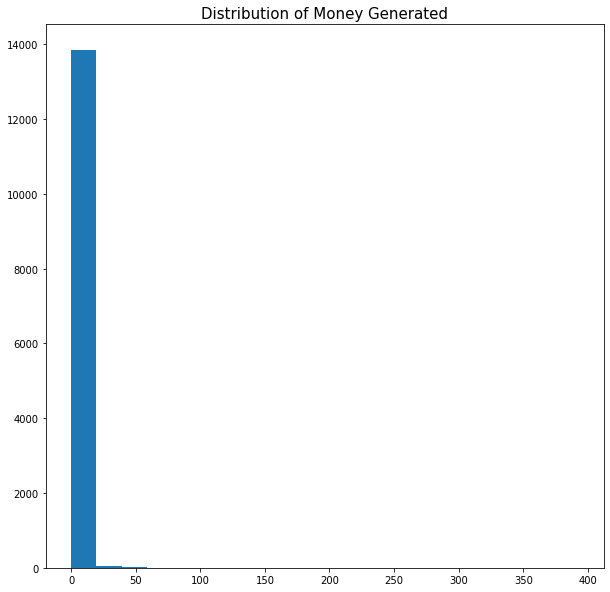

In [60]:
plt.figure(figsize=(10,10))
plt.title('Distribution of Money Generated',fontsize=15)
plt.hist(data['money_generated'], bins=20)
plt.show()

In [61]:
print(data['money_generated'].min())
print(data['money_generated'].max())
print(data['money_generated'].mean())
print(data['money_generated'].std())
data['money_generated'].quantile(q=0.95)

0.001534
392.5812440000003
0.8018862332183392
6.159175125090951


2.538085899999997

Looks like the target variable's statistics is distorted by an extreme outlier: max is 392 dollars, the mean is 80 dollars, whereas 90% of the sample contributed no more than 2.54 dollars. The max of 392 dollarscorresponds to 4,392 impressions. It's possible that this data point was generated by a bot or some software, not by human. We'll get rid of this outlier by limiting our dataset to only those falling within the 95th percentile. 

In [62]:
data = data.loc[(data['money_generated'] <=2.54)]

In [63]:
print(data.shape)

(13220, 25)


Thus, we have filtered out about 700 practitioners. Let's explore the distribution again.

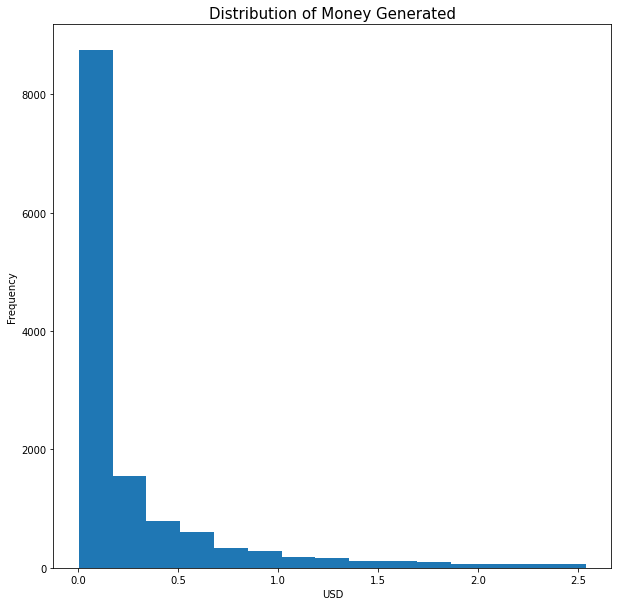

0.001534
2.5394520000000003
0.2577195036308629
0.4377620284117259


In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Distribution of Money Generated',fontsize=15)
plt.xlabel('USD',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.hist(data['money_generated'], bins=15)
plt.show()
print(data['money_generated'].min())
print(data['money_generated'].max())
print(data['money_generated'].mean())
print(data['money_generated'].std())

The data is still highly skewed to the right. One commonly applied method to normalize this type of distribution is to log-transform the original values. Let's create an additional column where we transform the values of 'money_generated' into their natural logarithmic values with a base of 10. 

In [65]:
import numpy as np
data['money_generated_log'] = np.log10(data['money_generated'])

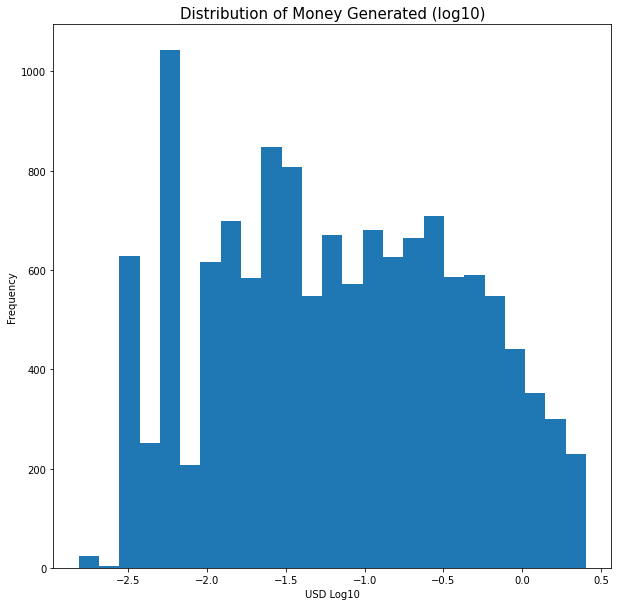

In [66]:
plt.figure(figsize=(10,10))
plt.xlabel('USD Log10',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Money Generated (log10)',fontsize=15)
plt.hist(data['money_generated_log'], bins=25)
plt.show()

While the resulting distribution is still far from looking normal, despite multimodality it now looks a lot better. Let's continue exploring the remaining variables.

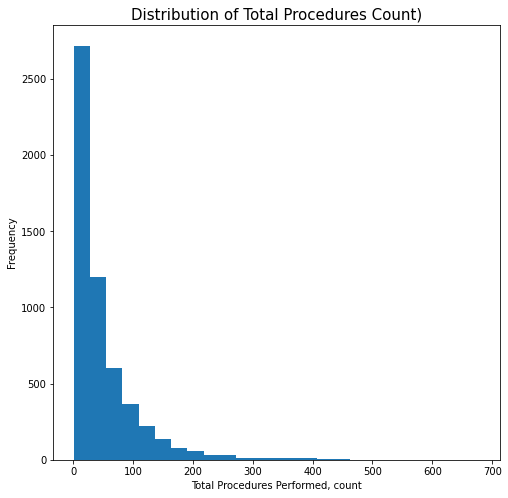

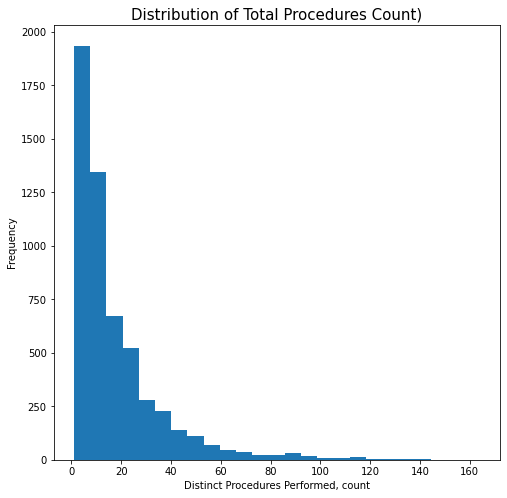

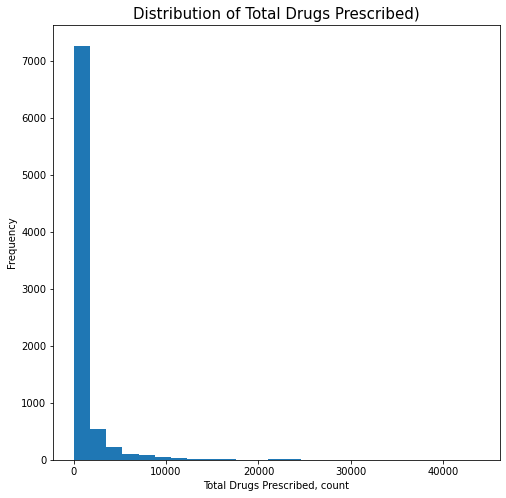

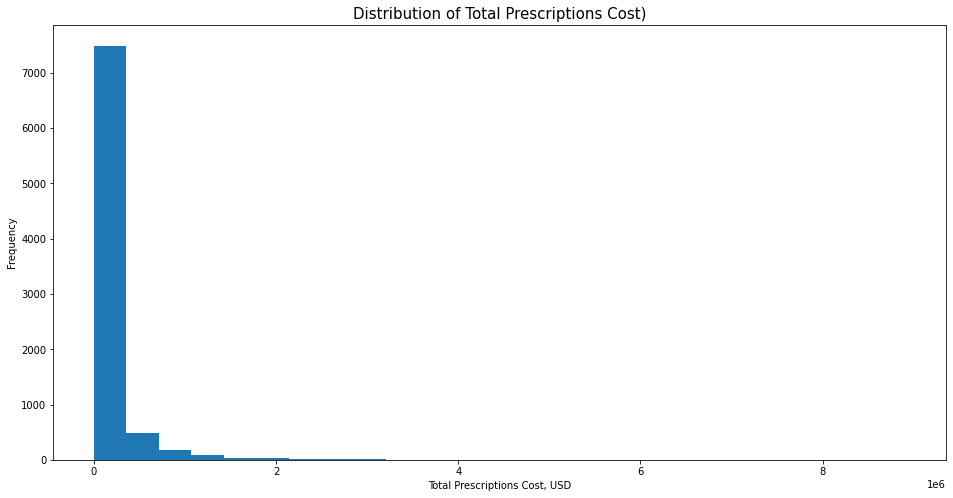

In [67]:
plt.figure(figsize=(8,8))
plt.xlabel('Total Procedures Performed, count',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Procedures Count)',fontsize=15)
plt.hist(data['total_procedures'], bins=25)
plt.show()

plt.figure(figsize=(8,8))
plt.xlabel('Distinct Procedures Performed, count',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Procedures Count)',fontsize=15)
plt.hist(data['distinct_procedures'], bins=25)
plt.show()


plt.figure(figsize=(8,8))
plt.xlabel('Total Drugs Prescribed, count',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Drugs Prescribed)',fontsize=15)
plt.hist(data['total_claim_count'], bins=25)
plt.show()

plt.figure(figsize=(16,8))
plt.xlabel('Total Prescriptions Cost, USD',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Prescriptions Cost)',fontsize=15)
plt.hist(data['total_drug_cost'], bins=25)
plt.show()

It appears that all the continious variables repeat the same distribution pattern as 'Money_Generated'. We'll log-transform them in the next step. In the meantime, the chart indicates the presence of extreme outliers in the 'total_drug_cost' variable that might tremendously distort its measures of central tendency

In [68]:
print(data['total_drug_cost'].min())
print(data['total_drug_cost'].max())
print(data['total_drug_cost'].mean())
print(data['total_drug_cost'].std())
data['total_drug_cost'].quantile(q=0.95)

22.09
8910558.52
132031.52094310318
387837.86996973737


674909.4475

Indeed, the max total cost of all drugs prescribed is 9M USD, whereas 95% of the sample prescribed drugs that cost less than 700K USD in total. Let's remove these outliers:

In [69]:
data = data.loc[(data['total_drug_cost'] <=675000)]
data.shape

(7947, 26)

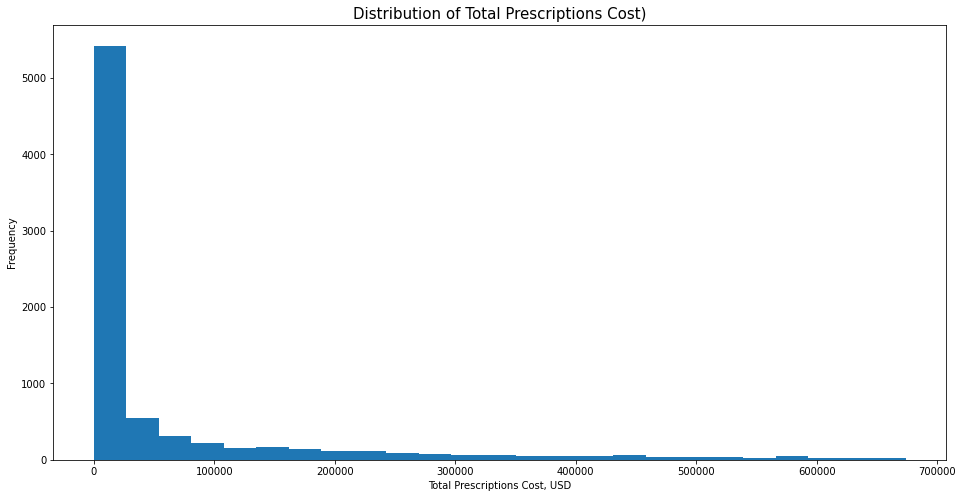

22.09
673753.72
64970.52236567253
128607.25114376072


In [70]:
plt.figure(figsize=(16,8))
plt.xlabel('Total Prescriptions Cost, USD',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Prescriptions Cost)',fontsize=15)
plt.hist(data['total_drug_cost'], bins=25)
plt.show()
print(data['total_drug_cost'].min())
print(data['total_drug_cost'].max())
print(data['total_drug_cost'].mean())
print(data['total_drug_cost'].std())

Indeed, the removal of only 5% of the sample lowered the mean by 50%! The distribution is still very skewed, so let's proceed with the log transformation of the variables. 

In [71]:
data['total_procedures_log'] = np.log10(data['total_procedures'])
data['distinct_procedures_log'] = np.log10(data['distinct_procedures'])
data['total_claim_count_log'] = np.log10(data['total_claim_count'])
data['total_drug_cost_log'] = np.log10(data['total_drug_cost'])

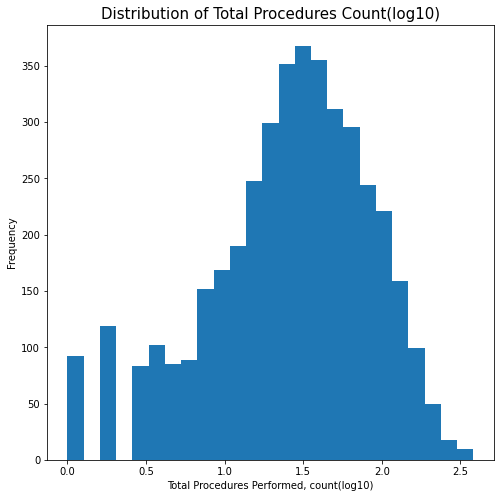

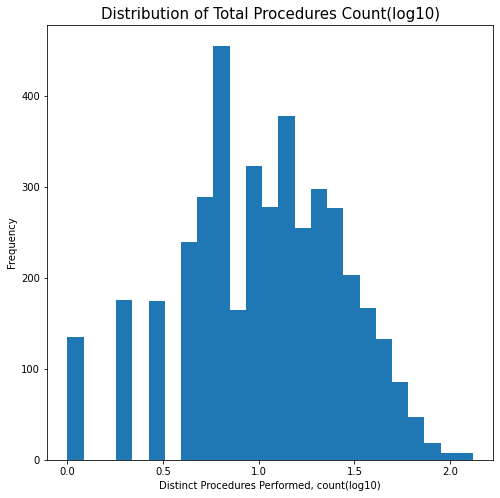

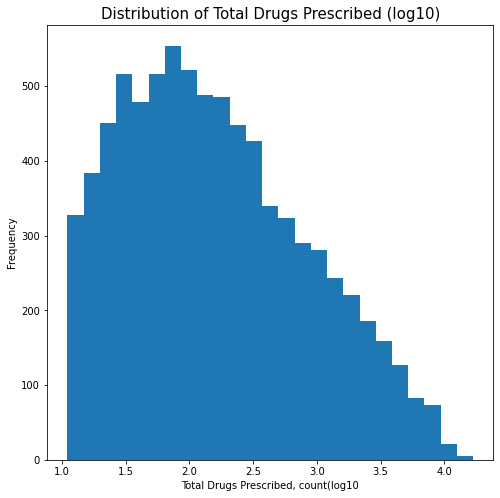

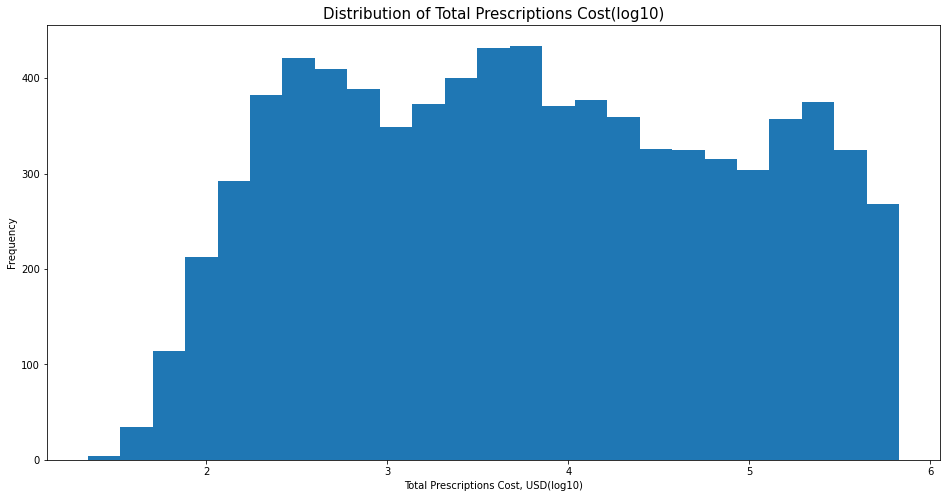

In [72]:
plt.figure(figsize=(8,8))
plt.xlabel('Total Procedures Performed, count(log10)',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Procedures Count(log10)',fontsize=15)
plt.hist(data['total_procedures_log'], bins=25)
plt.show()

plt.figure(figsize=(8,8))
plt.xlabel('Distinct Procedures Performed, count(log10)',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Procedures Count(log10)',fontsize=15)
plt.hist(data['distinct_procedures_log'], bins=25)
plt.show()


plt.figure(figsize=(8,8))
plt.xlabel('Total Drugs Prescribed, count(log10',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Drugs Prescribed (log10)',fontsize=15)
plt.hist(data['total_claim_count_log'], bins=25)
plt.show()

plt.figure(figsize=(16,8))
plt.xlabel('Total Prescriptions Cost, USD(log10)',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Prescriptions Cost(log10)',fontsize=15)
plt.hist(data['total_drug_cost_log'], bins=25)
plt.show()

The new distributions look a lot better!

In [73]:
data.to_csv('C:/Users/emich/Google Drive/Data science/Capstone 3/Data/Data_Continious_Vars_Cleaned.csv', index=False)

In [74]:
#Next steps: explore distinct values of categorical variables, recode, specialty specifically
data = pd.read_csv('C:/Users/emich/Google Drive/Data science/Capstone 3/Data/Data_Continious_Vars_Cleaned.csv')
print(data.head())

          npi  money_generated  impressions_count          city state zipcode  \
0  1003011610         0.129176                 32   NEWTONVILLE    MA   02460   
1  1003012436         0.003150                  1         ISLIP    NY   11751   
2  1003015785         0.022761                  1       Rutland    VT   05701   
3  1003025461         1.270086                 12  PHILADELPHIA    PA   19140   
4  1003029836         0.129028                  2     Stratford    NJ   08084   

  sole_proprietor                                          specialty  \
0               N                                  Internal Medicine   
1               N  Psychiatry and Neurology - Child and Adolescen...   
2               Y                                      Ophthalmology   
3               N                                  Internal Medicine   
4               N                                            Urology   

   total_procedures  distinct_procedures  ... hospital_longitude  \
0           

Let's explore categorical variables to see if they need any transformations.

In [75]:
print(data['state'].unique())

['MA' 'NY' 'VT' 'PA' 'NJ' 'TX' 'FL' 'OK' 'TN' 'NM' 'WA' 'CA' 'MI' 'MO'
 'SC' 'VA' 'MN' 'GA' 'IN' 'MD' 'OH' 'DE' 'NC' 'WI' 'LA' 'MT' 'HI' 'AL'
 'NV' nan 'IL' 'CO' 'UT' 'CT' 'AK' 'WV' 'IA' 'AZ' 'OR' 'PR' 'KY' 'RI' 'ND'
 'AR' 'NH' 'ME' 'SD' 'DC' 'MS' 'ID' 'NE' 'KS' 'WY' 'BC' 'VIC' 'ON' 'AP']


state 'VIC' looks suspicious

In [76]:
print(data.loc[data['state']=='VIC'])

             npi  money_generated  impressions_count       city state zipcode  \
4201  1528013224         1.389754                 24  Parkville   VIC    3052   

     sole_proprietor           specialty  total_procedures  \
4201               N  Emergency Medicine               NaN   

      distinct_procedures  ... hospital_longitude hospital_size  \
4201                  NaN  ...           -71.4965         Small   

      hospital_system_membership  total_claim_count total_drug_cost  \
4201                         NaN               28.0          230.97   

     money_generated_log total_procedures_log distinct_procedures_log  \
4201            0.142938                  NaN                     NaN   

      total_claim_count_log  total_drug_cost_log  
4201               1.447158             2.363556  

[1 rows x 30 columns]


Turns out that Parkville, VIC is located in Australia. We are interested in US recipients, so we'll drop these rows

In [77]:
data = data.drop([4201])

In [78]:
print(data['state'].unique())

['MA' 'NY' 'VT' 'PA' 'NJ' 'TX' 'FL' 'OK' 'TN' 'NM' 'WA' 'CA' 'MI' 'MO'
 'SC' 'VA' 'MN' 'GA' 'IN' 'MD' 'OH' 'DE' 'NC' 'WI' 'LA' 'MT' 'HI' 'AL'
 'NV' nan 'IL' 'CO' 'UT' 'CT' 'AK' 'WV' 'IA' 'AZ' 'OR' 'PR' 'KY' 'RI' 'ND'
 'AR' 'NH' 'ME' 'SD' 'DC' 'MS' 'ID' 'NE' 'KS' 'WY' 'BC' 'ON' 'AP']


This looks better. Moving onto the next variable, 'sole_proprietor' which reflects whether the doctor owns the practice they work at.

In [79]:
print(data['sole_proprietor'].value_counts())

N    5599
Y    2195
X     133
Name: sole_proprietor, dtype: int64


We see value X which I suspect can indicate a checkbox checked. So let's recode these values into 'Y'

In [80]:
data['sole_proprietor'].replace({'X':'Y'}, inplace=True)
print(data['sole_proprietor'].value_counts())

N    5599
Y    2328
Name: sole_proprietor, dtype: int64


Let's move onto Specialty.

In [81]:
print(data['specialty'].value_counts())

Internal Medicine                                                     1004
Dentist - General Practice                                             872
Dentist                                                                792
Emergency Medicine                                                     613
Family Medicine                                                        546
                                                                      ... 
Psychologist                                                             1
Physical Medicine and Rehabilitation - Spinal Cord Injury Medicine       1
Emergency Medicine - Medical Toxicology                                  1
Internal Medicine - Addiction Medicine                                   1
Plastic Surgery - Surgery of the Hand                                    1
Name: specialty, Length: 177, dtype: int64


177 distinct specialties sounds like too many for a meaningful analysis.The format of this variable is "Broad Specialty - Specialization". We'll get rid of specializations and group doctors by broader practice areas. On the other hand, 'Internal Medicine' seems to be too broad, let's see how many distinct specialties there are. 

In [82]:
internal_medicine = data[data.specialty.str.startswith('Internal')]
print(internal_medicine['specialty'].value_counts())


Internal Medicine                                            1004
Internal Medicine - Cardiovascular Disease                    223
Internal Medicine - Gastroenterology                          139
Internal Medicine - Nephrology                                 88
Internal Medicine - Pulmonary Disease                          52
Internal Medicine - Diabetes and Metabolism Endocrinology      51
Internal Medicine - Hematology and Oncology                    47
Internal Medicine - Critical Care Medicine                     35
Internal Medicine - Infectious Disease                         31
Internal Medicine - Rheumatology                               29
Internal Medicine - Medical Oncology                           17
Internal Medicine - Interventional Cardiology                  16
Internal Medicine - Geriatric Medicine                         15
Internal Medicine - Clinical Cardiac Electrophysiology         11
Internal Medicine - Hospice and Palliative Medicine             9
Internal M

Let's recode some of the frequent values into separate specialties:

In [83]:
data.replace({'specialty' : {'Internal Medicine - Cardiovascular Disease': 'Cardiology',
                             'Internal Medicine - Gastroenterology': 'Gastroenterology',
                             'Internal Medicine - Geriatric Medicine': 'Geriatric Medicine',
                             'Internal Medicine - Pulmonary Disease': 'Pulmonolgy',
                             'Internal Medicine - Hematology and Oncology': 'Hematology and Oncology',
                             'Internal Medicine - Infectious Disease': 'Infectious Disease',
                             'Internal Medicine - Interventional Cardiology': 'Cardiology',
                             'Internal Medicine - Bariatric Medicine': 'Bariatric Medicine',
                             'Internal Medicine - Critical Care Medicine': 'Emergency Medicine',
                             'Internal Medicine - Nephrology': 'Nephrology',
                             'Internal Medicine - Diabetes and Metabolism Endocrinology': 'Endocrinology',
                             'Internal Medicine - Medical Oncology': 'Hematology and Oncology',
                             'Internal Medicine - Clinical Cardiac Electrophysiology':'Cardiology',
                             'Internal Medicine - Rheumatology': 'Rheumatology',
                             'Internal Medicine - Sports Medicine':'Sports Medicine',
                             'Internal Medicine - Hematology':'Hematology and Oncology',
                             'Internal Medicine - Adult Congenital Heart Disease':'Cardiology'
                             
                             
                             
                             
                             
                             
                             
}}, inplace=True)

In [84]:
data['specialty'] = data['specialty'].str.split(' -',1).str[0]

In [85]:
specialty_list = data['specialty'].unique()
print(len(specialty_list))
print(data['specialty'].value_counts())

64
Dentist                                  1865
Internal Medicine                        1022
Emergency Medicine                        672
Psychiatry and Neurology                  572
Family Medicine                           560
                                         ... 
Clinical Medical Laboratory                 1
Acupuncturist                               1
Nuclear Medicine                            1
Clinic/Center                               1
Personal Emergency Response Attendant       1
Name: specialty, Length: 64, dtype: int64


In [86]:
data['specialty'].unique()

array(['Internal Medicine', 'Psychiatry and Neurology', 'Ophthalmology',
       'Urology', 'Dentist', 'Independent Medical Examiner',
       'Family Medicine', 'Emergency Medicine', 'Cardiology',
       'Dermatology', 'Obstetrics and Gynecology', 'Radiology',
       'Orthopaedic Surgery',
       'Student in an Organized Health Care Education/Training Program',
       'Optometrist', 'Surgery', 'Anesthesiology', 'Plastic Surgery',
       'General Practice', 'Neurological Surgery', 'Specialist',
       'Pulmonolgy', 'Nephrology', 'Hospitalist', 'Pain Medicine',
       'Gastroenterology', 'Otolaryngology', 'Hematology and Oncology',
       'Infectious Disease', 'Physical Medicine and Rehabilitation',
       'Allergy and Immunology', 'Pharmacist', 'Geriatric Medicine',
       'Oral and Maxillofacial Surgery', 'Endocrinology',
       'Nurse Practitioner', 'Rheumatology', 'Physician Assistant',
       'Pediatrics', 'Neuromusculoskeletal Medicine and OMM',
       'Podiatrist', 'Advanced Heart 

Let's combine some of the values that are within the same treatment areas, e.g group all surgeons and nurses to reduce the count of categories

In [87]:
data.replace({'specialty' : { 'Certified Registered Nurse Anesthetist' :'Nurse/PA/Technician', 
                             'Clinical Nurse Specialist' : 'Nurse/PA/Technician', 'Physician Assistant' : 'Nurse/PA/Technician',
                          'Nurse Practitioner':'Nurse/PA/Technician', 'Registered Nurse': 'Nurse/PA/Technician',
                           'Specialist': 'Nurse/PA/Technician', 'Specialist/Technologist':'Nurse/PA/Technician',
                            'Colon and Rectal Surgery':'Surgery', 'Female Pelvic Medicine and Reconstructive Surgery':'Surgery',
                             'Neurological Surgery':'Surgery','Oral and Maxillofacial Surgery':'Surgery',
                             'Orthopaedic Surgery':'Surgery','Plastic Surgery':'Surgery',
                             'Thoracic Surgery (Cardiothoracic Vascular Surgery)':'Surgery','Transplant Surgery':'Surgery',
                             'Personal Emergency Response Attendant':'Emergency Medicine',
                             'MS Genetic Counselor':'Medical Genetics',
                             'Neuromusculoskeletal Medicine Sports Medicine':'Sports Medicine',
                             'Optometrist':'Ophthalmology', 
                             'Speech-Language Pathologist':'Pathology', 
                             'Pharmacy Technician':'Pharmacist',
                             'Physical Medicine and Rehabilitation':'Physical Therapist',
                             'Rehabilitation Practitioner':'Physical Therapist',
                             'Prevention Professional':'Preventive Medicine',
                             'Student in an Organized Health Care Education/Training Program': 'Student',
                             'Advanced Heart Failure & Transplant Cardiology': 'Cardiology'
}}, inplace=True)

In [88]:
specialty_list = data['specialty'].unique()
print(len(specialty_list))
print(data['specialty'].value_counts())

47
Dentist                                  1865
Internal Medicine                        1022
Emergency Medicine                        673
Psychiatry and Neurology                  572
Family Medicine                           560
Surgery                                   377
Student                                   349
Ophthalmology                             335
Dermatology                               328
Obstetrics and Gynecology                 268
Cardiology                                256
Urology                                   171
Nurse/PA/Technician                       167
Gastroenterology                          139
Nephrology                                 88
Radiology                                  81
Anesthesiology                             71
Hematology and Oncology                    68
Otolaryngology                             60
Physical Therapist                         58
Pediatrics                                 55
Pharmacist                     

This looks a lot cleaner! Let's move onto the next variable, publicationid, which indicates which NewsLetter the receipient receives

In [89]:
data['publicationid'].value_counts()

AMA           3596
ADA           1898
ACEP           410
APA            276
AAD            245
AOA            196
ACC            183
AUA            169
CCF            154
AMAWEEKEND     128
AGA            106
ASCO            98
ASN             78
ASHP            67
ATS             64
ACOG            59
ENDO            58
ACPE            28
SEMPA           25
TMA             22
RDB             17
AMCP            16
NAPNAP          11
CHEST           11
ACRAD           10
MSSNY            9
DIA              6
ASCP             4
OSTEO            2
Name: publicationid, dtype: int64

Publicationid seems to be clean. Let's explore 'is_pii_enabled' which indicates whether the recipient allows sharing personal information with advertisers

In [90]:
data['is_pii_enabled'].value_counts()

b'\x00'    6897
b'\x01'    1049
Name: is_pii_enabled, dtype: int64

Wow, this one looks bad! Value of 0 in the original dataset meant that PII sharing was not allowed, whereas value of 1 meant it is OK to share the recipient's personal data with advertisers. Let's recode this variable

In [91]:
#data['is_pii_enabled'] = data['is_pii_enabled'].str.split('x',1).str[1]
#data['is_pii_enabled'] = data['is_pii_enabled'].str.split("'",1).str[0]
data.replace({'is_pii_enabled':{'00': 0, '01':1}}, inplace=True)
data['is_pii_enabled'].value_counts()

b'\x00'    6897
b'\x01'    1049
Name: is_pii_enabled, dtype: int64

Let's move onto 'hospital_system_membership'. We saw earlier that it was only coded for 'Yes', but not for 'N'. Let's add this value and recode the variable into 1 for 'Yes' and 0 for 'No'

In [92]:
data['hospital_system_membership'].value_counts()

Y    2239
Name: hospital_system_membership, dtype: int64

In [93]:
data['hospital_system_membership'] = data['hospital_system_membership'].astype(object)
data.replace({'hospital_system_membership':{'Y':1}}, inplace=True)
data['hospital_system_membership'].fillna(0, inplace=True)
data['hospital_system_membership'].value_counts()

0.0    5707
1.0    2239
Name: hospital_system_membership, dtype: int64

Moving on to the next variable, the state where the hospital in which the doctor works is located.

In [94]:
data['hospital_state'].value_counts()

CA             297
NY             256
TX             216
FL             201
PA             187
IL             178
MA             156
OH             126
NC             124
NJ             120
MI             107
MN              89
GA              80
VA              79
WI              73
WA              70
MD              66
MO              64
IN              57
TN              57
CT              55
AZ              55
CO              45
SC              41
OR              39
LA              36
KY              35
UT              29
AL              25
IA              24
NH              22
DC              21
AR              21
MS              21
RI              20
NV              18
WV              17
OK              16
ME              16
KS              16
NM              16
DE              15
HI              15
ID              15
NE              14
MT              12
VT               9
SD               8
WY               7
AK               6
ND               6
Puerto Rico      5
Name: hospit

Nothing looks particularly suspicious here, so we can examine the next variable, the size of the hospital where each doctor works.

In [95]:
data['hospital_size'].value_counts()

Large     1461
Medium    1460
Small      382
Name: hospital_size, dtype: int64

Hospital size looks OK. Let's move on to the last variable, 'derived_specialty_list'. This gives us additional information about each doctor's specialty. More specifically treatment areas in which doctors works if the specialty is multidisciplinary. The each value in a column represents a set of specialty codes. My assumption is that the more disciplines there are in the set, the more often the doctor will be targeted by different advertisers. Out task here is to transform this variable so that we get the counts of items in each set instead of specific codes.

In [96]:
data['derived_specialty_list'].value_counts()

EM                       461
P                        312
IM,MPD                   266
D                        236
OBG                      195
                        ... 
CCM,EM,RESIDENT            1
GS,DR                      1
CD,CTR,IM,ISM ,MPD,TS      1
GP,FP,MDM,OBG              1
DR,HEM,HO,ON,STUDENT       1
Name: derived_specialty_list, Length: 1220, dtype: int64

We'll count subspecialties in each set by counting commas in that set and then adding 1 to the number of commas:

In [97]:
data['comma_count'] = data['derived_specialty_list'].str.count(',')
print(data['comma_count'])
data['sub_specialty_count'] = data['comma_count'] +1
print (data['sub_specialty_count'])
data['sub_specialty_count'].value_counts()

0       2.0
1       0.0
2       1.0
3       5.0
4       0.0
       ... 
7942    NaN
7943    NaN
7944    0.0
7945    NaN
7946    2.0
Name: comma_count, Length: 7946, dtype: float64
0       3.0
1       1.0
2       2.0
3       6.0
4       1.0
       ... 
7942    NaN
7943    NaN
7944    1.0
7945    NaN
7946    3.0
Name: sub_specialty_count, Length: 7946, dtype: float64


1.0     2158
2.0     1616
3.0     1215
4.0      607
5.0      164
6.0       59
7.0       18
8.0        7
9.0        2
10.0       1
11.0       1
Name: sub_specialty_count, dtype: int64

In [98]:
data.drop(['comma_count'], axis=1,inplace=True)

We've dropped the column we no longer need. Let's save the cleaned dataset.

In [99]:
data.to_csv('C:/Users/emich/Google Drive/Data science/Capstone 3/Data/Data_Cleaned.csv')